In [1]:
import sys
import os
import json
import glob
import copy
import h5py
import time
import pdb
import functools
import multiprocessing
import numpy as np
import scipy.signal
import scipy.io.wavfile
%matplotlib inline
import matplotlib.pyplot as plt
import IPython.display as ipd

sys.path.append('packages/bez2018model')
import bez2018model

sys.path.append('packages/msutil')
import util_figures
import util_stimuli
import util_misc


In [2]:
def adaptive_threshold_measurement(f0,
                                   t,
                                   sr=100e3,
                                   dBSPL_max=100.0,
                                   dBSPL_step=1.0,
                                   kwargs_nervegram={}):
    '''
    '''
    dBSPL = dBSPL_max
    list_meanrate = []
    list_dBSPL = []
    while True:
        y = np.sin(2 * np.pi * f0 * t + (np.pi/2 * np.random.rand()))
        y = util_stimuli.set_dBSPL(y, dBSPL)
        out_dict = bez2018model.nervegram(y, sr, **kwargs_nervegram)
        list_meanrate.append(np.mean(np.squeeze(out_dict['nervegram_meanrates'])))
        list_dBSPL.append(dBSPL)
        if list_meanrate[-1] > kwargs_nervegram.get('spont', 70.0) * 1.1:
            dBSPL -= dBSPL_step
        else:
            break
    return dBSPL


def get_ANF_tuning(cf,
                   kwargs_nervegram_update={},
                   list_f0=np.exp(np.linspace(np.log(1e2), np.log(1e4), 250)),
                   max_processes=60,
                   sr=100e3,
                   dBSPL_max=100.0,
                   dBSPL_step=1.0):
    '''
    '''
    kwargs_nervegram = {
        'nervegram_dur': 0.050,
        'nervegram_fs': 20e3,
        'buffer_start_dur': 0.070,
        'buffer_end_dur': 0.010,
        'pin_fs': 100e3,
        'pin_dBSPL_flag': 0,
        'pin_dBSPL': None,
        'species': 2,
        'bandwidth_scale_factor': 1.0,
        'cf_list': None,
        'num_cf': 1,
        'min_cf': cf,
        'max_cf': cf,
        'max_spikes_per_train': 500,
        'num_spike_trains': 1,
        'cohc': 1.0,
        'cihc': 1.0,
        'IhcLowPass_cutoff': 3000,
        'IhcLowPass_order': 7,
        'spont': 70.0,
        'noiseType': 0,
        'implnt': 0,
        'tabs': 6e-4,
        'trel': 6e-4,
        'random_seed': None,
        'return_vihcs': False,
        'return_meanrates': True,
        'return_spike_times': False,
        'return_spike_tensor_sparse': False,
        'return_spike_tensor_dense': False,
        'nervegram_spike_tensor_fs': 100e3,
    }
    kwargs_nervegram.update(kwargs_nervegram_update)
    
    dur = kwargs_nervegram['nervegram_dur']
    dur += kwargs_nervegram['buffer_start_dur']
    dur += kwargs_nervegram['buffer_end_dur']
    t = np.arange(0, dur, 1/sr)
    
    parallel_wrapper = functools.partial(
        adaptive_threshold_measurement,
        t,
        sr=sr,
        dBSPL_max=dBSPL_max,
        dBSPL_step=dBSPL_step,
        kwargs_nervegram=kwargs_nervegram,
    )
    
    with multiprocessing.Pool(processes=np.min([len(list_f0), max_processes])) as pool:
        list_thresholds = pool.map(parallel_wrapper, list_f0)
    
    return list_f0, list_thresholds


dict_kwargs_nervegram_update = {
#     'ohc_loss': {'cohc': 0.0},
    'human': {'bandwidth_scale_factor': 1.0},
    'narrow': {'bandwidth_scale_factor': 0.5},
    'broad': {'bandwidth_scale_factor': 2.0},
    'linear': {'bandwidth_scale_factor': 80.0, 'species': 4},
}
dict_results = {}

list_cf = [250.0, 5e2, 1e3, 2e3, 4e3]

for key in sorted(dict_kwargs_nervegram_update.keys()):
    dict_results[key] = []
    t0 = time.time()
    for cf in list_cf:
        list_f0, list_thresholds = get_ANF_tuning(
            cf=cf,
            kwargs_nervegram_update=dict_kwargs_nervegram_update[key])
        dict_results[key].append(list_thresholds)
    print(key, time.time() - t0)


broad 43.259313106536865
human 38.70353722572327
linear 37.295511960983276
narrow 35.677562952041626


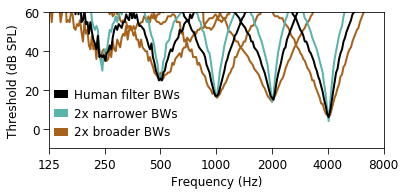

In [4]:
fig, ax = plt.subplots(figsize=(6, 2.5))
# fig, ax = plt.subplots(figsize=(4, 3))

color_list = util_figures.get_color_list(8, cmap_name='Accent')
dict_kwargs_plot = {
#     'ohc_loss': {'c': color_list[5], 'label': '0% OHC function', 'lw': 3},
#     'human': {'c': color_list[4], 'label': '100% OHC function', 'zorder': 1, 'lw': 3},

    'narrow': {'c': '#5ab4ac', 'label': '2x narrower BWs', 'zorder': 0, 'lw': 2},
    'human': {'c': 'k', 'label': 'Human filter BWs', 'zorder': 1, 'lw': 2},
    'broad': {'c': '#a6611a', 'label': '2x broader BWs', 'zorder': -1, 'lw': 2},
    'linear': {'c': '#f768a1', 'label': 'Linearly spaced', 'lw': 2},
}

list_keys_to_plot = [
    'human',
    'narrow',
    'broad',
    
#     'human',
#     'linear',
    
#     'ohc_loss',
#     'human',
]

for key in list_keys_to_plot:
    for itr0, list_thresholds in enumerate(dict_results[key]):
        if itr0 > 0:
            dict_kwargs_plot[key]['label'] = None
        ax.plot(list_f0, list_thresholds, **dict_kwargs_plot[key])
#         print(key, np.min(list_thresholds))

xticks = [list_cf[0]/2] + list_cf + [list_cf[-1]*2]
if 'ohc_loss' in list_keys_to_plot:
    ylimits = [-10, 90]
else:
    ylimits = [-10, 60]
ax = util_figures.format_axes(
    ax,
    xscale='log',
    str_xlabel='Frequency (Hz)',
    str_ylabel='Threshold (dB SPL)',
    str_title=None,
    xticks=xticks,
    xticklabels=np.array(xticks).astype(int),
    xticks_minor=[],
    xlimits=[xticks[0], xticks[-1]],
    ylimits=ylimits)
legend_plot_kwargs = {
    'loc': 'lower left',
    'ncol': 1,
    'borderpad': 0.4,
    'borderaxespad': 0.4,
    'handletextpad': 0.8,
    'frameon': False,
    'handlelength': 0.5,
    'markerscale': 1.0,
    'fontsize': 12,
}
leg = ax.legend(**legend_plot_kwargs)
for legobj in leg.legendHandles:
    legobj.set_linewidth(8.0)

plt.show()

# fig.savefig('tmp.pdf', bbox_inches='tight', pad_inches=0, transparent=True)


In [ ]:
# fn = '/om/user/msaddler/data_pitchnet/bernox2005/neurophysiology_v02_inharmonic_fixed_EqualAmpTEN_lharm01to15_phase0_f0min080_f0max640_seed862/stim.hdf5'
fn = '/om/user/msaddler/data_pitchnet/mcpherson2020/testspl_v03/stim.hdf5'
with h5py.File(fn, 'r') as f:
    for v in f.values():
        print(v)
    IDX = -500
    y = f['tone_in_noise'][IDX]    

sr = 32e3
fxx, pxx = util_stimuli.power_spectrum(y, sr)

print(util_stimuli.get_dBSPL(y))
fig, ax = plt.subplots(figsize=(6, 2.5))
ax.plot(fxx, pxx, 'k-')
ax = util_figures.format_axes(
    ax,
    str_xlabel='Frequency (Hz)',
    str_ylabel='dB/Hz SPL',
    str_title=None,
    xlimits=[0, sr/4],
    ylimits=[None, None])
plt.show()

ipd.display(ipd.Audio(y, rate=sr))
